In [1]:
from imutils import contours
import imutils
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

Imagem Original


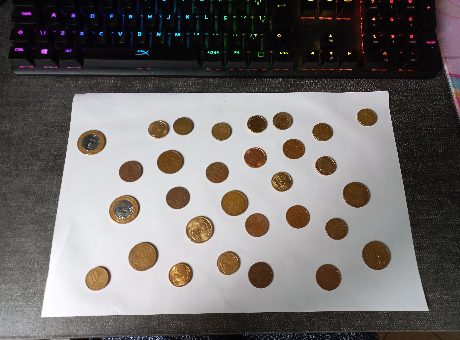

In [2]:
WIDTH = 460
HEIGHT = 340

image = cv2.imread("coins.jpg")
image = cv2.resize(image, (WIDTH, HEIGHT))

print("Imagem Original")
cv2_imshow(image)

Perspective Gray


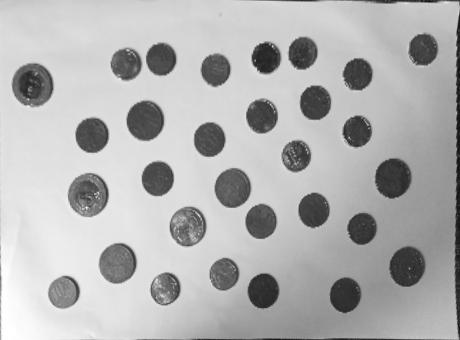

In [3]:
corners = [[76, 96], [388, 90], [40, 316], [430, 311]]

########################################################################
source_points = np.float32(corners)
output_points = np.float32([[0,0],[WIDTH,0],[0,HEIGHT],[WIDTH,HEIGHT]])
M = cv2.getPerspectiveTransform(source_points, output_points)
image = cv2.warpPerspective(image,M,(WIDTH,HEIGHT))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
########################################################################

print("Perspective Gray")
cv2_imshow(gray)

Edged


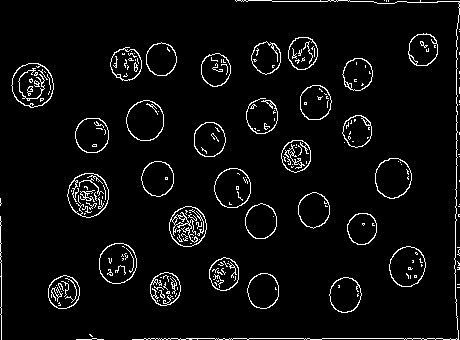

In [4]:
###################################
edged = cv2.Canny(gray, 50, 100)
###################################

print("Edged")
cv2_imshow(edged)

Seg


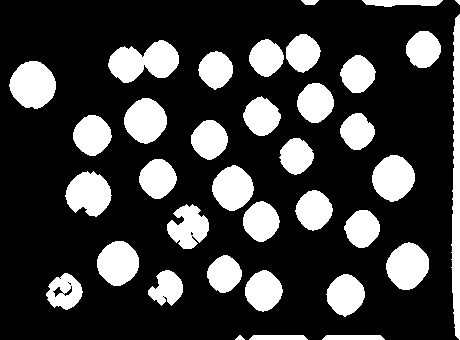

In [5]:
###################################################################################
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
thresh = cv2.erode(thresh, None, iterations=1)
thresh = cv2.dilate(thresh, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=4)
###################################################################################

print("Seg")
cv2_imshow(thresh)

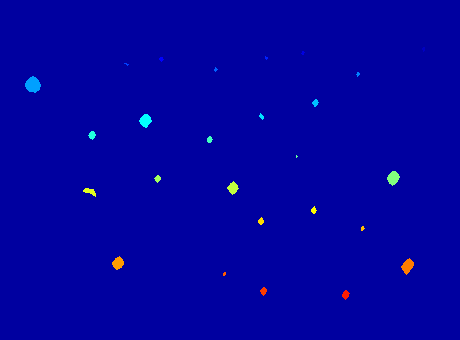

watershed


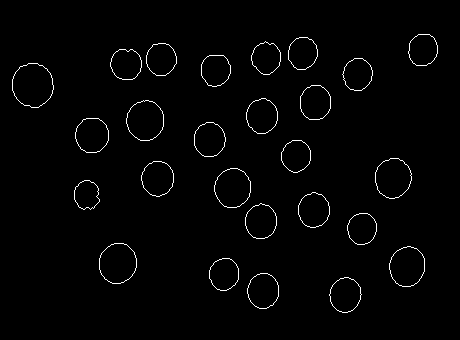

In [22]:
#######################################################################################
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
sure_bg = cv2.dilate(opening,kernel,iterations=3)
dist_transform = cv2.distanceTransform(thresh,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

ret, markers = cv2.connectedComponents(sure_fg)
markers = markers+1

show = markers.astype(np.uint8)*8
show = cv2.applyColorMap(show, cv2.COLORMAP_JET)
cv2_imshow(show)

markers[unknown==255] = 0

markers = cv2.watershed(image, markers)

nrow = len(markers)
ncol = len(markers[0])
water = gray.copy()
for i in range(nrow):
	for j in range(ncol):
		if markers[i][j] == -1 and 0 < i and i < nrow - 1 and 0 < j and j < ncol - 1 :
			water[i][j] = 255
		else:
			water[i][j] = 0
#######################################################################################

print("watershed")
cv2_imshow(water)

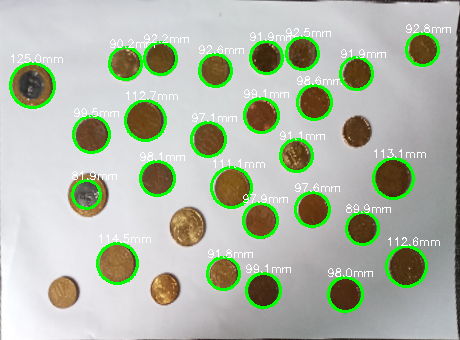

In [ ]:
cnts = cv2.findContours(water.copy(), cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

(cnts, _) = contours.sort_contours(cnts)
COINSIZE = 125
mmPerPixel = None

orig = image.copy()
for c in cnts:
	# if the contour is not sufficiently large, ignore it
    if cv2.contourArea(c) < 100:
        continue
	# compute the rotated bounding box of the contour
    (x,y),radius = cv2.minEnclosingCircle(c)
    cv2.circle(orig,(int(x),int(y)),int(radius),(0,255,0),2)

    if mmPerPixel is None:
        mmPerPixel = COINSIZE / radius

    cv2.putText(orig, "{:.1f}mm".format(mmPerPixel * radius),
                (int(x - radius), int(y - radius)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.36, (255, 255, 255), 1)

cv2_imshow(orig)